<a href="https://colab.research.google.com/github/camilavincensi/TCC-previsao-commodities/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parte 1: Treinando e Testando o Modelo RNN apenas com precos_diarios_soja_milho_parana_ajustado.csv

Epoch 1/100
21/21 [==============================] - 4s 40ms/step - loss: 0.1262
Epoch 2/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0905
Epoch 3/100
21/21 [==============================] - 1s 29ms/step - loss: 0.0825
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0809
Epoch 5/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0815
Epoch 6/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0847
Epoch 7/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0822
Epoch 8/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0807
Epoch 9/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0791
Epoch 10/100
21/21 [==============================] - 0s 24ms/step - loss: 0.0835
Epoch 11/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0785
Epoch 12/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0804
Epoch 13/100
21/21 [=====

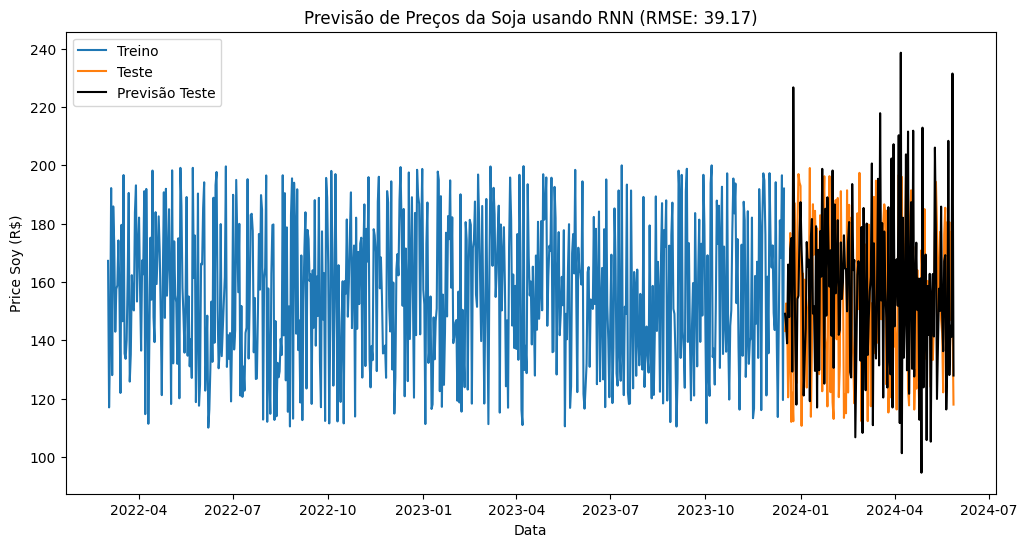

Epoch 1/100
21/21 [==============================] - 2s 23ms/step - loss: 0.2008
Epoch 2/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0918
Epoch 3/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0855
Epoch 4/100
21/21 [==============================] - 1s 26ms/step - loss: 0.0861
Epoch 5/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0821
Epoch 6/100
21/21 [==============================] - 1s 29ms/step - loss: 0.0825
Epoch 7/100
21/21 [==============================] - 1s 27ms/step - loss: 0.0837
Epoch 8/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0832
Epoch 9/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0790
Epoch 10/100
21/21 [==============================] - 1s 26ms/step - loss: 0.0785
Epoch 11/100
21/21 [==============================] - 1s 26ms/step - loss: 0.0778
Epoch 12/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0775
Epoch 13/100
21/21 [=====

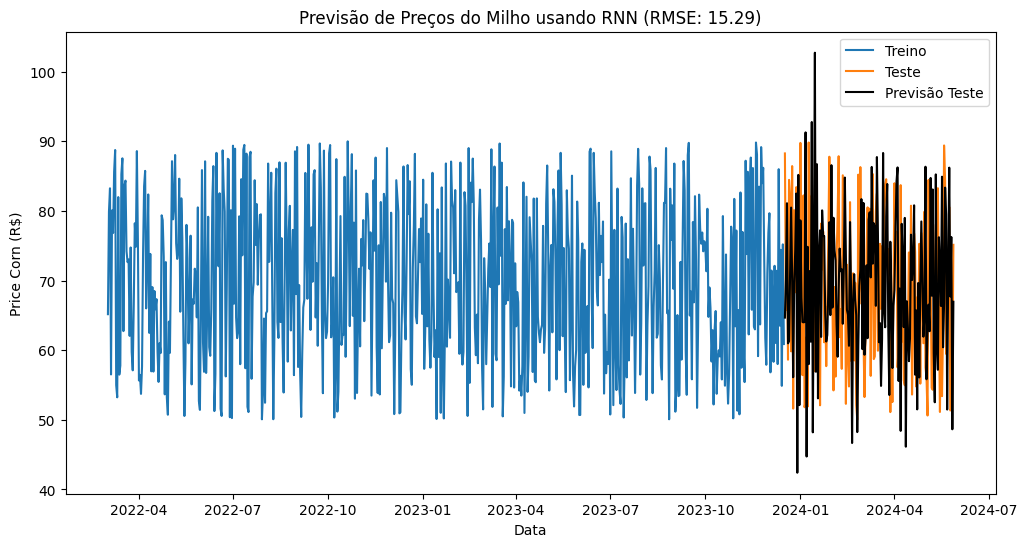

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error

# Carregar o arquivo precos_diarios_soja_milho_parana_ajustado.csv
commodities_prices_path = 'precos_diarios_soja_milho_parana_ajustado.csv'
commodities_prices = pd.read_csv(commodities_prices_path, encoding='latin1', delimiter=',')

# Renomear as colunas
commodities_prices.columns = ['Date', 'Price Soy (R$)', 'Price Corn (R$)']

# Converter a coluna de data para o formato datetime
commodities_prices['Date'] = pd.to_datetime(commodities_prices['Date'], format='%Y-%m-%d')

# Função para treinar e prever usando RNN
def train_and_predict_rnn(prices_column, title):
    # Selecionar a série temporal
    prices = commodities_prices[['Date', prices_column]].drop_duplicates()

    # Normalizar os dados
    scaler_prices = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler_prices.fit_transform(prices[prices_column].values.reshape(-1, 1))

    # Preparar os dados para a RNN
    X = []
    y = []
    time_step = 60
    for i in range(time_step, len(prices_scaled)):
        X.append(prices_scaled[i-time_step:i, 0])
        y.append(prices_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Dividir os dados em conjuntos de treino e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Criar e compilar o modelo RNN
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(SimpleRNN(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Fazer previsões
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverter a normalização
    train_predict = scaler_prices.inverse_transform(train_predict)
    test_predict = scaler_prices.inverse_transform(test_predict)
    y_train = scaler_prices.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_prices.inverse_transform(y_test.reshape(-1, 1))

    # Avaliar o desempenho do modelo
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))

    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.plot(prices['Date'][time_step:train_size+time_step], y_train, label='Treino')
    plt.plot(prices['Date'][train_size+time_step:], y_test, label='Teste')
    plt.plot(prices['Date'][train_size+time_step:], test_predict, label='Previsão Teste', color='black')
    plt.xlabel('Data')
    plt.ylabel(prices_column)
    plt.title(f'{title} (RMSE: {test_score:.2f})')
    plt.legend()
    plt.show()

# Treinar e prever para soja
train_and_predict_rnn('Price Soy (R$)', 'Previsão de Preços da Soja usando RNN')

# Treinar e prever para milho
train_and_predict_rnn('Price Corn (R$)', 'Previsão de Preços do Milho usando RNN')


Parte 2: Treinando e Testando o Modelo RNN com precos_diarios_soja_milho_parana_ajustado.csv e combined_climate_data.csv

Epoch 1/100
21/21 [==============================] - 46s 2s/step - loss: 0.1661
Epoch 2/100
21/21 [==============================] - 44s 2s/step - loss: 0.0865
Epoch 3/100
21/21 [==============================] - 44s 2s/step - loss: 0.0915
Epoch 4/100
21/21 [==============================] - 44s 2s/step - loss: 0.0836
Epoch 5/100
21/21 [==============================] - 43s 2s/step - loss: 0.0840
Epoch 6/100
21/21 [==============================] - 43s 2s/step - loss: 0.0823
Epoch 7/100
21/21 [==============================] - 43s 2s/step - loss: 0.0852
Epoch 8/100
21/21 [==============================] - 43s 2s/step - loss: 0.0802
Epoch 9/100
21/21 [==============================] - 43s 2s/step - loss: 0.0816
Epoch 10/100
21/21 [==============================] - 44s 2s/step - loss: 0.0807
Epoch 11/100
21/21 [==============================] - 43s 2s/step - loss: 0.0791
Epoch 12/100
21/21 [==============================] - 43s 2s/step - loss: 0.0780
Epoch 13/100
21/21 [=================

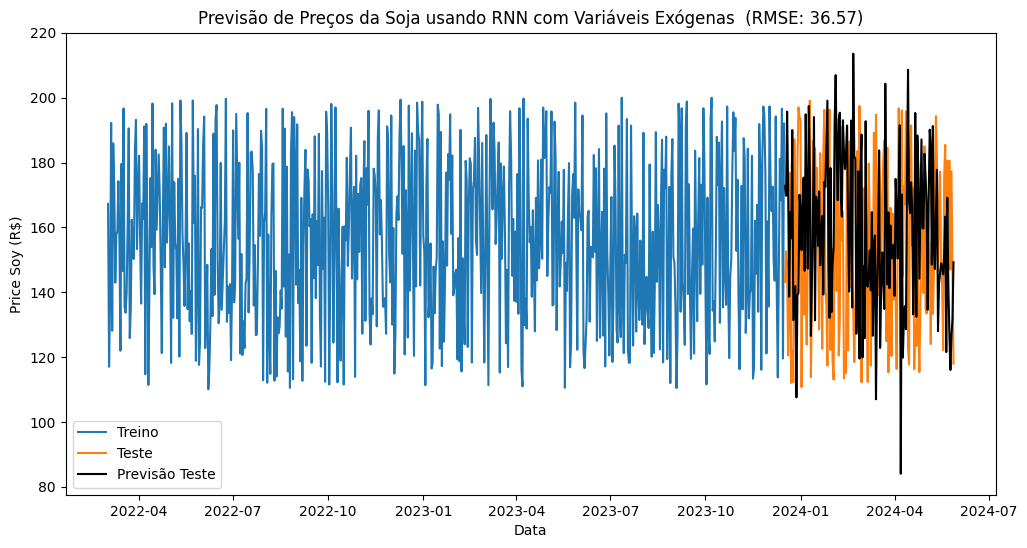

Epoch 1/100
21/21 [==============================] - 44s 2s/step - loss: 0.1495
Epoch 2/100
21/21 [==============================] - 43s 2s/step - loss: 0.0902
Epoch 3/100
21/21 [==============================] - 42s 2s/step - loss: 0.0959
Epoch 4/100
21/21 [==============================] - 41s 2s/step - loss: 0.0835
Epoch 5/100
21/21 [==============================] - 42s 2s/step - loss: 0.0835
Epoch 6/100
21/21 [==============================] - 42s 2s/step - loss: 0.0844
Epoch 7/100
21/21 [==============================] - 42s 2s/step - loss: 0.0872
Epoch 8/100
21/21 [==============================] - 42s 2s/step - loss: 0.0835
Epoch 9/100
21/21 [==============================] - 43s 2s/step - loss: 0.0839
Epoch 10/100
21/21 [==============================] - 42s 2s/step - loss: 0.0846
Epoch 11/100
21/21 [==============================] - 41s 2s/step - loss: 0.0809
Epoch 12/100
21/21 [==============================] - 42s 2s/step - loss: 0.0898
Epoch 13/100
21/21 [=================

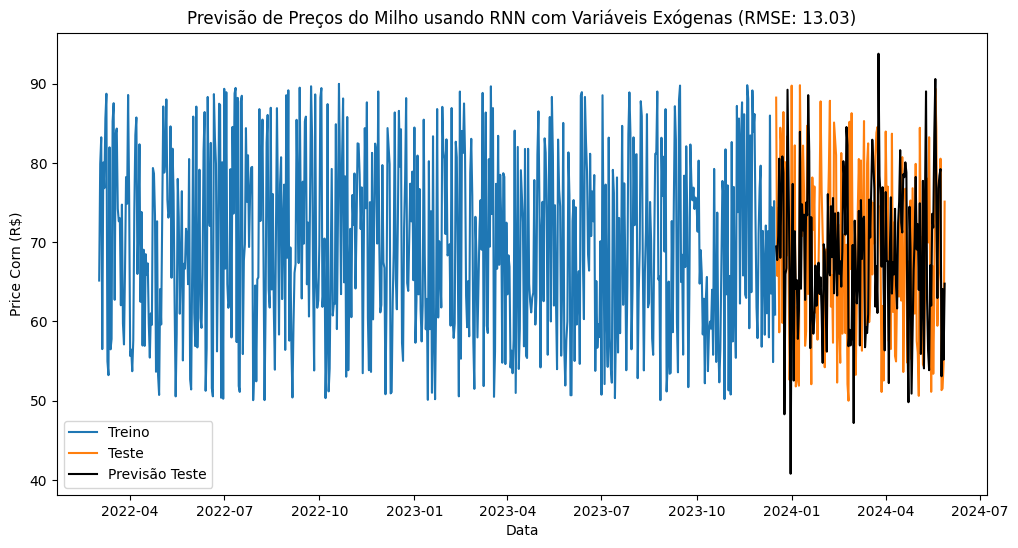

In [ ]:
# Carregar o arquivo combined_climate_data.csv
climate_data_path = 'combined_climate_data.csv'
climate_data = pd.read_csv(climate_data_path, encoding='latin1', delimiter=',')

# Renomear as colunas
climate_data.columns = ['Date', 'Country', 'City', 'Temperature (C)', 'Humidity (%)', 'Precipitation (mm)']

# Converter a coluna de data para o formato datetime
climate_data['Date'] = pd.to_datetime(climate_data['Date'], format='%Y-%m-%d')

# Pivotar o dataframe de climate_data para que cada cidade seja uma coluna
climate_data_pivot = climate_data.pivot(index='Date', columns='City', values=['Temperature (C)', 'Humidity (%)', 'Precipitation (mm)'])

# Flatten the multi-level columns
climate_data_pivot.columns = ['_'.join(col).strip() for col in climate_data_pivot.columns.values]

# Unir os dataframes com base na coluna de data
merged_data_climate = pd.merge(commodities_prices, climate_data_pivot, on='Date', how='left')

# Remover duplicatas na coluna de data
merged_data_climate = merged_data_climate.drop_duplicates(subset=['Date'])

# Função para treinar e prever usando RNN
def train_and_predict_rnn_climate(prices_column, title):
    # Selecionar a série temporal e variáveis exógenas
    prices = merged_data_climate[['Date', prices_column]].drop_duplicates()
    exog_variables = merged_data_climate[[col for col in merged_data_climate.columns if 'Temperature' in col or 'Humidity' in col or 'Precipitation' in col]].fillna(method='ffill')

    # Normalizar os dados
    scaler_prices = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler_prices.fit_transform(prices[prices_column].values.reshape(-1, 1))
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    exog_scaled = scaler_exog.fit_transform(exog_variables)

    # Preparar os dados para a RNN
    X = []
    y = []
    time_step = 60
    for i in range(time_step, len(prices_scaled)):
        X.append(np.concatenate((prices_scaled[i-time_step:i, 0], exog_scaled[i-time_step:i].flatten())))
        y.append(prices_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Dividir os dados em conjuntos de treino e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Criar e compilar o modelo RNN
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(SimpleRNN(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Fazer previsões
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverter a normalização
    train_predict = scaler_prices.inverse_transform(train_predict)
    test_predict = scaler_prices.inverse_transform(test_predict)
    y_train = scaler_prices.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_prices.inverse_transform(y_test.reshape(-1, 1))

    # Avaliar o desempenho do modelo
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))

    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.plot(prices['Date'][time_step:train_size+time_step], y_train, label='Treino')
    plt.plot(prices['Date'][train_size+time_step:], y_test, label='Teste')
    plt.plot(prices['Date'][train_size+time_step:], test_predict, label='Previsão Teste', color='black')

    plt.xlabel('Data')
    plt.ylabel(prices_column)
    plt.title( f'{title} (RMSE: {test_score:.2f})')
    plt.legend()
    plt.show()

# Treinar e prever para soja
train_and_predict_rnn_climate('Price Soy (R$)', 'Previsão de Preços da Soja usando RNN com Variáveis Exógenas ')

# Treinar e prever para milho
train_and_predict_rnn_climate('Price Corn (R$)', 'Previsão de Preços do Milho usando RNN com Variáveis Exógenas')


Parte 3: Treinando e Testando o Modelo RNN com precos_diarios_soja_milho_parana_ajustado.csv e historical_data.csv

Epoch 1/100
21/21 [==============================] - 11s 295ms/step - loss: 0.1875
Epoch 2/100
21/21 [==============================] - 5s 252ms/step - loss: 0.0873
Epoch 3/100
21/21 [==============================] - 7s 326ms/step - loss: 0.0819
Epoch 4/100
21/21 [==============================] - 5s 260ms/step - loss: 0.0803
Epoch 5/100
21/21 [==============================] - 5s 256ms/step - loss: 0.0807
Epoch 6/100
21/21 [==============================] - 7s 348ms/step - loss: 0.0805
Epoch 7/100
21/21 [==============================] - 3s 130ms/step - loss: 0.0837
Epoch 8/100
21/21 [==============================] - 2s 85ms/step - loss: 0.0809
Epoch 9/100
21/21 [==============================] - 2s 87ms/step - loss: 0.0783
Epoch 10/100
21/21 [==============================] - 3s 159ms/step - loss: 0.0795
Epoch 11/100
21/21 [==============================] - 2s 92ms/step - loss: 0.0814
Epoch 12/100
21/21 [==============================] - 2s 87ms/step - loss: 0.0777
Epoch 13/100
21/

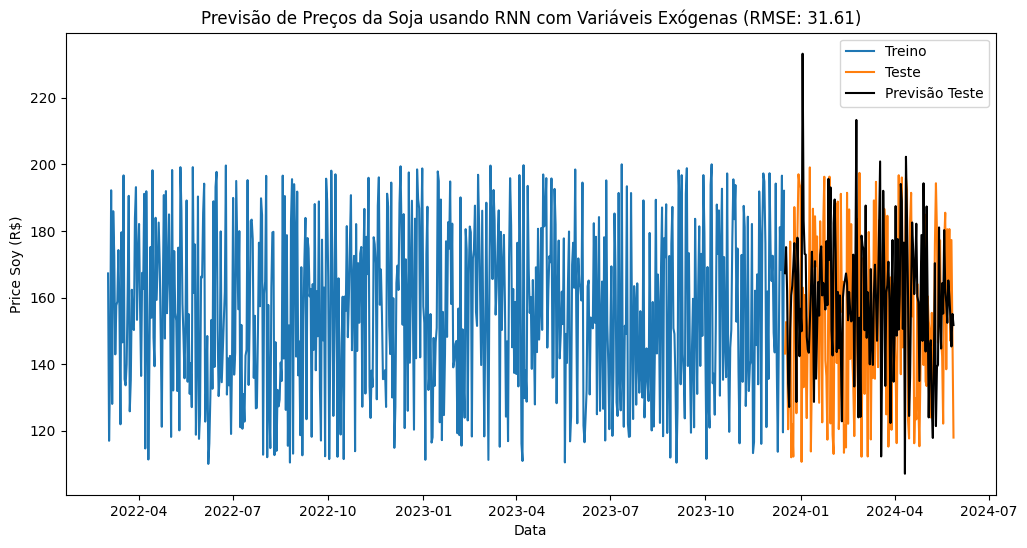

Previsão de Preços da Soja usando RNN com Variáveis Exógenas - Train Score: 5.04 RMSE
Previsão de Preços da Soja usando RNN com Variáveis Exógenas - Test Score: 31.61 RMSE
Epoch 1/100
21/21 [==============================] - 4s 90ms/step - loss: 0.1782
Epoch 2/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0907
Epoch 3/100
21/21 [==============================] - 2s 90ms/step - loss: 0.0858
Epoch 4/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0846
Epoch 5/100
21/21 [==============================] - 2s 111ms/step - loss: 0.0816
Epoch 6/100
21/21 [==============================] - 3s 156ms/step - loss: 0.0826
Epoch 7/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0851
Epoch 8/100
21/21 [==============================] - 2s 90ms/step - loss: 0.0878
Epoch 9/100
21/21 [==============================] - 2s 90ms/step - loss: 0.0810
Epoch 10/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0848
Epoch 11/100
21

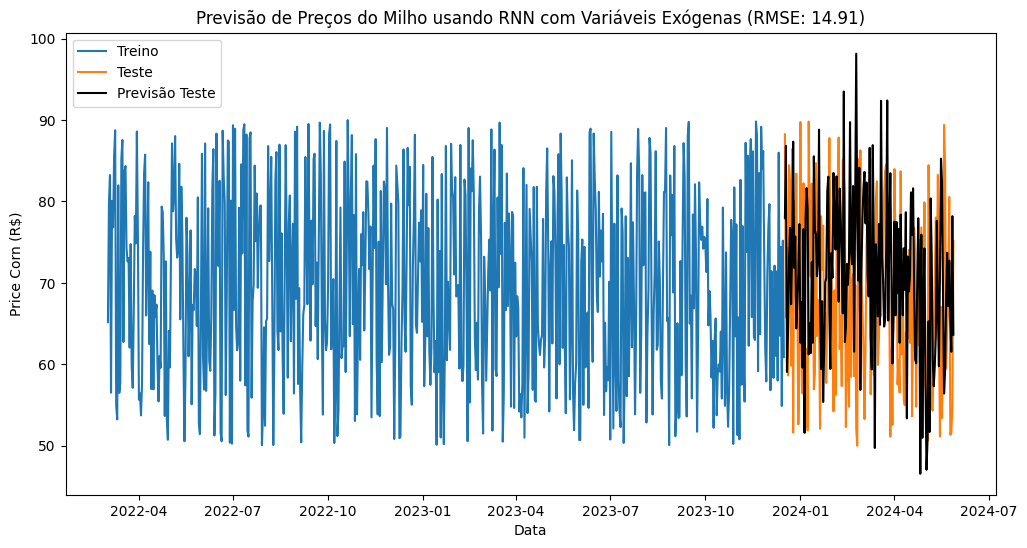

Previsão de Preços do Milho usando RNN com Variáveis Exógenas - Train Score: 1.92 RMSE
Previsão de Preços do Milho usando RNN com Variáveis Exógenas - Test Score: 14.91 RMSE


In [5]:
# Carregar o arquivo historical_data.csv
historical_data_path = 'historical_data.csv'
historical_data = pd.read_csv(historical_data_path, encoding='latin1', delimiter=',')

# Renomear as colunas
historical_data.columns = ['Date', 'Crude Oil Price (USD/barrel)', 'USD/BRL', 'IBOVESPA']

# Converter a coluna de data para o formato datetime
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d')

# Unir os dataframes com base na coluna de data
merged_data_historical = pd.merge(commodities_prices, historical_data, on='Date', how='left')

# Remover duplicatas na coluna de data
merged_data_historical = merged_data_historical.drop_duplicates(subset=['Date'])

# Função para treinar e prever usando RNN
def train_and_predict_rnn_historical(prices_column, title):
    # Selecionar a série temporal e variáveis exógenas
    prices = merged_data_historical[['Date', prices_column]].drop_duplicates()
    exog_variables = merged_data_historical[['Crude Oil Price (USD/barrel)', 'USD/BRL', 'IBOVESPA']].fillna(method='ffill')

    # Normalizar os dados
    scaler_prices = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler_prices.fit_transform(prices[prices_column].values.reshape(-1, 1))
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    exog_scaled = scaler_exog.fit_transform(exog_variables)

    # Preparar os dados para a RNN
    X = []
    y = []
    time_step = 60
    for i in range(time_step, len(prices_scaled)):
        X.append(np.concatenate((prices_scaled[i-time_step:i, 0], exog_scaled[i-time_step:i].flatten())))
        y.append(prices_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Dividir os dados em conjuntos de treino e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Criar e compilar o modelo RNN
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(SimpleRNN(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Fazer previsões
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverter a normalização
    train_predict = scaler_prices.inverse_transform(train_predict)
    test_predict = scaler_prices.inverse_transform(test_predict)
    y_train = scaler_prices.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_prices.inverse_transform(y_test.reshape(-1, 1))

    # Avaliar o desempenho do modelo
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))

    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.plot(prices['Date'][time_step:train_size+time_step], y_train, label='Treino')
    plt.plot(prices['Date'][train_size+time_step:], y_test, label='Teste')
    plt.plot(prices['Date'][train_size+time_step:], test_predict, label='Previsão Teste', color='black')
    plt.xlabel('Data')
    plt.ylabel(prices_column)
    plt.title(f'{title} (RMSE: {test_score:.2f})')
    plt.legend()
    plt.show()

    print(f'{title} - Train Score: {train_score:.2f} RMSE')
    print(f'{title} - Test Score: {test_score:.2f} RMSE')

# Treinar e prever para soja
train_and_predict_rnn_historical('Price Soy (R$)', 'Previsão de Preços da Soja usando RNN com Variáveis Exógenas')

# Treinar e prever para milho
train_and_predict_rnn_historical('Price Corn (R$)', 'Previsão de Preços do Milho usando RNN com Variáveis Exógenas')


Parte 4: Treinando e Testando o Modelo RNN com a junção dos três arquivos

Epoch 1/100
21/21 [==============================] - 51s 2s/step - loss: 0.1459
Epoch 2/100
21/21 [==============================] - 49s 2s/step - loss: 0.0848
Epoch 3/100
21/21 [==============================] - 49s 2s/step - loss: 0.0866
Epoch 4/100
21/21 [==============================] - 47s 2s/step - loss: 0.0838
Epoch 5/100
21/21 [==============================] - 49s 2s/step - loss: 0.0835
Epoch 6/100
21/21 [==============================] - 47s 2s/step - loss: 0.0839
Epoch 7/100
21/21 [==============================] - 50s 2s/step - loss: 0.0859
Epoch 8/100
21/21 [==============================] - 50s 2s/step - loss: 0.0845
Epoch 9/100
21/21 [==============================] - 48s 2s/step - loss: 0.0826
Epoch 10/100
21/21 [==============================] - 49s 2s/step - loss: 0.0811
Epoch 11/100
21/21 [==============================] - 48s 2s/step - loss: 0.0803
Epoch 12/100
21/21 [==============================] - 49s 2s/step - loss: 0.0877
Epoch 13/100
21/21 [=================

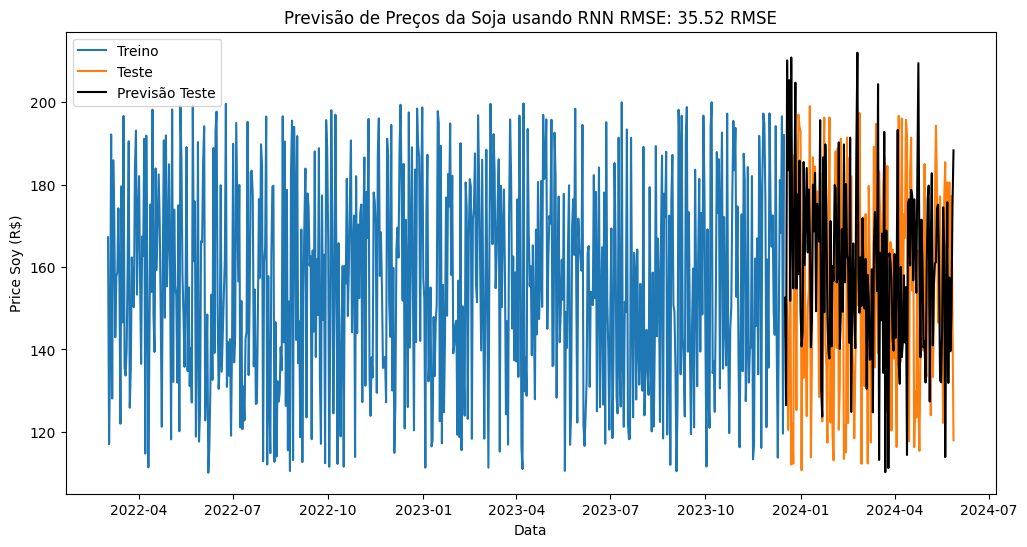

Epoch 1/100
21/21 [==============================] - 50s 2s/step - loss: 0.1271
Epoch 2/100
21/21 [==============================] - 48s 2s/step - loss: 0.0847
Epoch 3/100
21/21 [==============================] - 46s 2s/step - loss: 0.0844
Epoch 4/100
21/21 [==============================] - 48s 2s/step - loss: 0.0881
Epoch 5/100
21/21 [==============================] - 47s 2s/step - loss: 0.0827
Epoch 6/100
21/21 [==============================] - 48s 2s/step - loss: 0.0839
Epoch 7/100
21/21 [==============================] - 47s 2s/step - loss: 0.0837
Epoch 8/100
21/21 [==============================] - 49s 2s/step - loss: 0.0872
Epoch 9/100
21/21 [==============================] - 47s 2s/step - loss: 0.0832
Epoch 10/100
21/21 [==============================] - 48s 2s/step - loss: 0.0877
Epoch 11/100
21/21 [==============================] - 47s 2s/step - loss: 0.0825
Epoch 12/100
21/21 [==============================] - 48s 2s/step - loss: 0.0818
Epoch 13/100
21/21 [=================

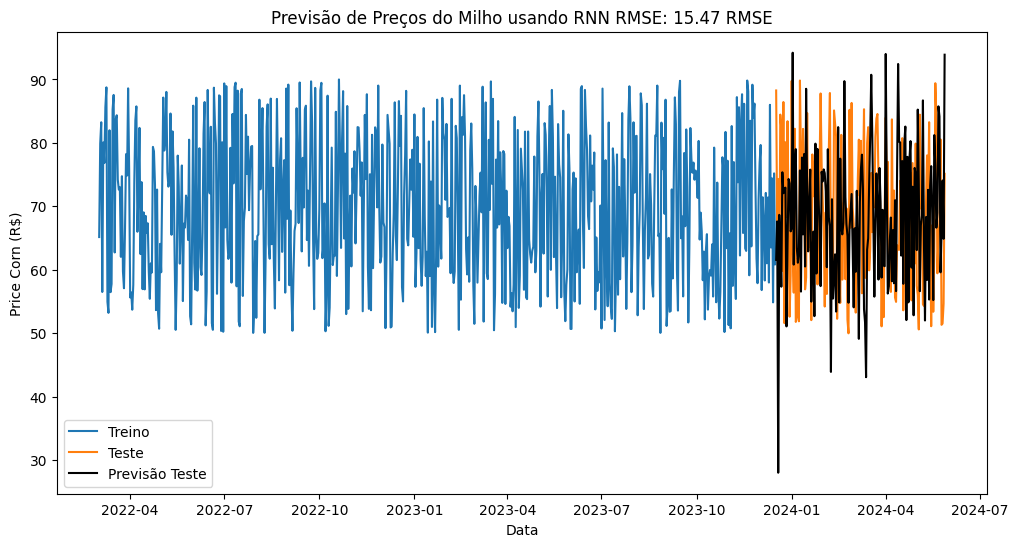

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error

# Carregar os dados dos arquivos enviados pelo usuário
climate_data_path = 'combined_climate_data.csv'
historical_data_path = 'historical_data.csv'
commodities_prices_path = 'precos_diarios_soja_milho_parana_ajustado.csv'

climate_data = pd.read_csv(climate_data_path, encoding='latin1', delimiter=',')
historical_data = pd.read_csv(historical_data_path, encoding='latin1', delimiter=',')
commodities_prices = pd.read_csv(commodities_prices_path, encoding='latin1', delimiter=',')

# Renomear as colunas
climate_data.columns = ['Date', 'Country', 'City', 'Temperature (C)', 'Humidity (%)', 'Precipitation (mm)']
historical_data.columns = ['Date', 'Crude Oil Price (USD/barrel)', 'USD/BRL', 'IBOVESPA']
commodities_prices.columns = ['Date', 'Price Soy (R$)', 'Price Corn (R$)']

# Converter as colunas de data para o formato datetime
climate_data['Date'] = pd.to_datetime(climate_data['Date'], format='%Y-%m-%d')
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d')
commodities_prices['Date'] = pd.to_datetime(commodities_prices['Date'], format='%Y-%m-%d')

# Pivotar o dataframe de climate_data para que cada cidade seja uma coluna
climate_data_pivot = climate_data.pivot(index='Date', columns='City', values=['Temperature (C)', 'Humidity (%)', 'Precipitation (mm)'])

# Flatten the multi-level columns
climate_data_pivot.columns = ['_'.join(col).strip() for col in climate_data_pivot.columns.values]

# Unir os dataframes com base na coluna de data
merged_data = pd.merge(commodities_prices, climate_data_pivot, on='Date', how='left')
merged_data = pd.merge(merged_data, historical_data, on='Date', how='left')

# Remover duplicatas na coluna de data
merged_data = merged_data.drop_duplicates(subset=['Date'])

merged_data.head()

# Função para treinar e prever usando RNN
def train_and_predict_rnn(prices_column, title):
    # Selecionar a série temporal e variáveis exógenas
    prices = merged_data[['Date', prices_column]].drop_duplicates()
    exog_variables = merged_data[[col for col in merged_data.columns if 'Temperature' in col or 'Humidity' in col or 'Precipitation' in col] +
                                 ['Crude Oil Price (USD/barrel)', 'USD/BRL', 'IBOVESPA']].fillna(method='ffill')

    # Normalizar os dados
    scaler_prices = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler_prices.fit_transform(prices[prices_column].values.reshape(-1, 1))
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    exog_scaled = scaler_exog.fit_transform(exog_variables)

    # Preparar os dados para a RNN
    X = []
    y = []
    time_step = 60
    for i in range(time_step, len(prices_scaled)):
        X.append(np.concatenate((prices_scaled[i-time_step:i, 0], exog_scaled[i-time_step:i].flatten())))
        y.append(prices_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Dividir os dados em conjuntos de treino e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Criar e compilar o modelo RNN
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(SimpleRNN(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Fazer previsões
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverter a normalização
    train_predict = scaler_prices.inverse_transform(train_predict)
    test_predict = scaler_prices.inverse_transform(test_predict)
    y_train = scaler_prices.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_prices.inverse_transform(y_test.reshape(-1, 1))

    # Avaliar o desempenho do modelo
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))

    # Plotar os resultados
    plt.figure(figsize=(12, 6))
    plt.plot(prices['Date'][time_step:train_size+time_step], y_train, label='Treino')
    plt.plot(prices['Date'][train_size+time_step:], y_test, label='Teste')
    plt.plot(prices['Date'][train_size+time_step:], test_predict, label='Previsão Teste', color='black')
    plt.xlabel('Data')
    plt.ylabel(prices_column)
    plt.title(f'{title} RMSE: {test_score:.2f} RMSE')
    plt.legend()
    plt.show()

# Treinar e prever para soja
train_and_predict_rnn('Price Soy (R$)', 'Previsão de Preços da Soja usando RNN')

# Treinar e prever para milho
train_and_predict_rnn('Price Corn (R$)', 'Previsão de Preços do Milho usando RNN')